# 이진 판단


## 시그모이드 함수
시그모이드 함수는 범위에 제한 없는 임의의 실수값을 입력으로 받아 확률값의 범위에 해당하는 0과 1 사이의 값을 출력하는 함수이다.  

시그모이드 함수는 다음과 같이 나타낸다.  
$$ \sigma(x) = \frac{1}{1 + e^{-x}}$$

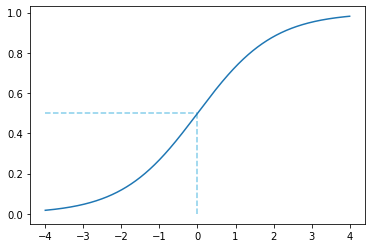

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x_data = np.arange(-4, 4, 0.001)
y_data = sigmoid(x_data)

plt.plot(x_data, y_data)
plt.vlines(0, 0, 0.5, colors='skyblue', linestyles='--')
plt.hlines(0.5, -4, 0, colors='skyblue', linestyles='--')

### 확률 분포와 정보 엔트로피
정보 엔트로피는 확률 분포의 무질서도나 불확실성 혹은 정보 표현의 부담 정도를 나타내며  

$$\sum_{i=1}^m \frac{1}{a_i}log \,a_i $$  

다음과 같은 식으로 표현한다.  
여기서 $p_i = \frac{1}{a_i} $로 치환해 주로 표현한다. 그럼 최종식은 다음과 같다. 

$$ H = -\sum_{i=1}^m p_ilog\,{p_i} $$  

이렇게 정의된 정보 엔트로피는 어떤 확률분포로 일어나는 사건을 표현하는 데 필요한 정보량이다. 이 값이 커질수록 확률 분포의 불확실성이 커져 결과 예측이 어려워진다.  

### 확률 분포의 추정과 교차 엔트로피

교차 엔트로피는 두 확률 분포가 얼마나 비슷한지를 숫자로 나타내는 개념이다.  

정보 엔트로피에서 확률 값 $p_i$의 정보량을 $-log
\,{p_i}$라 정의하면 정보 엔트로피는 각각의 정보량에 가중 평균을 구한다는 의미로서 해석할 수 있다.  

이 개념을 갖고와 교차 엔트로피에 적용하면  
$q_1, \cdots, q_n$의 확률 분포 $Q$에 따른 정보량을 갖는 사건이 $p_1, \cdots, p_n$의 확률 분포 $P$에 따라 일어날 때 이를 다음과 같이 표현할 수 있다.  

$$ H(P, Q) = -\sum{p_i log \,q_i} $$

또한,  
$$ H(P, P)  = -\sum{p_i log \,p_i} = H$$  
이므로 $P$와 $Q$의 확률 분포가 동일할 때만 같은 값을 갖으며 보통은 $H(P, Q)$ 가 더 크다.   
$H(P, Q) \ge H(P, P)$

### 시그모이드 교차 엔트로피와 편미분
이진 판단 문제에서 정답이 $z$로 주어졌을때 로짓값 $x$를 출력했다고 하면 다음과 같은 식이 성립한다.  

$$ H = x - xz + log\,(1+e^{-x})$$

이값을 $x$애 대한 편미분을 진행하면 다음과 같은 식이 도출된다.  

$$ \frac{\partial{H}}{\partial{x}} = -z + \sigma(x) $$

### 계산값 폭주 문제와 시그모이드 관련 함수의 안전한 계산법
시그모이드 함수의 경우 큰 음수의 값이 주어지게 되면 파이썬에선 오버플로우가 발생했다는 메세지를 출력한다. 이를 방지하기 위해서 다음과 같은 방법을 사용한다.  

$$ \sigma(x) = \frac{e^{-max(-x, 0)}}{1 + e^{-|x|}} $$
$$ H = max(x, 0) - xz + log\,(1 + e^{-|x|})$$

## 펄서 여부 판정 신경망


### 펄서 스타 데이터
펄서는 전파를 생성하는 중성자 별로 8개의 변수와 이진 클래스를 갖는 타겟 변수를 갖고 있습니다.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip

--2021-01-29 10:20:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1563015 (1.5M) [application/x-httpd-php]
Saving to: ‘HTRU2.zip’

HTRU2.zip           100%[===================>]   1.49M  3.81MB/s    in 0.4s    

2021-01-29 10:20:23 (3.81 MB/s) - ‘HTRU2.zip’ saved [1563015/1563015]



In [ ]:
!unzip HTRU2.zip

Archive:  HTRU2.zip
  inflating: HTRU_2.csv              
  inflating: HTRU_2.arff             
  inflating: Readme.txt              


### 파이썬 모듈 불러들이기

In [ ]:
import numpy as np
import csv
import time

np.random.seed(1234)

def randomize():
    np.random.seed(time.time())

### 하이퍼파라미터값의 정의

In [ ]:
RND_MEAN = 0
RND_STD = 0.0030

LEARNING_RATE = 0.001

### 파라미터 초기화 함수 정의

In [ ]:
def init_model():
    global weight, bias, input_cnt, output_cnt
    weight = np.random.normal(RND_MEAN, RND_STD,[input_cnt, output_cnt])
    bias = np.zeros([output_cnt])

### 학습 및 평가 함수 정의

In [ ]:
def train_and_test(epoch_count, mb_size, report):
    step_count = arrange_data(mb_size)
    test_x, test_y = get_test_data()
    
    for epoch in range(epoch_count):
        losses, accs = [], []
        
        for n in range(step_count):
            train_x, train_y = get_train_data(mb_size, n)
            loss, acc = run_train(train_x, train_y)
            losses.append(loss)
            accs.append(acc)
            
        if report > 0 and (epoch+1) % report == 0:
            acc = run_test(test_x, test_y)
            print('Epoch {}: loss={:5.3f}, accuracy={:5.3f}/{:5.3f}'. \
                  format(epoch+1, np.mean(losses), np.mean(accs), acc))
            
    final_acc = run_test(test_x, test_y)
    print('\nFinal Test: final accuracy = {:5.3f}'.format(final_acc))

### 학습 및 평가  데이터 획득 함수 정의

In [ ]:
def arrange_data(mb_size):
    global data, shuffle_map, test_begin_idx
    shuffle_map = np.arange(data.shape[0])
    np.random.shuffle(shuffle_map)
    step_count = int(data.shape[0] * 0.8) // mb_size
    test_begin_idx = step_count * mb_size
    return step_count

def get_test_data():
    global data, shuffle_map, test_begin_idx, output_cnt
    test_data = data[shuffle_map[test_begin_idx:]]
    return test_data[:, :-output_cnt], test_data[:, -output_cnt:]

def get_train_data(mb_size, nth):
    global data, shuffle_map, test_begin_idx, output_cnt
    if nth == 0:
        np.random.shuffle(shuffle_map[:test_begin_idx])
    train_data = data[shuffle_map[mb_size*nth:mb_size*(nth+1)]]
    return train_data[:, :-output_cnt], train_data[:, -output_cnt:]

### 학습 실행 함수와 평가 실행 함수 정의

In [ ]:
def run_train(x, y):
    output, aux_nn = forward_neuralnet(x)
    loss, aux_pp = forward_postproc(output, y)
    accuracy = eval_accuracy(output, y)
    
    G_loss = 1.0
    G_output = backprop_postproc(G_loss, aux_pp)
    backprop_neuralnet(G_output, aux_nn)
    
    return loss, accuracy

def run_test(x, y):
    output, _ = forward_neuralnet(x)
    accuracy = eval_accuracy(output, y)
    return accuracy

### 단층 퍼셉트론에 대한 순전파 및 역전파 함수 정의

In [ ]:
def forward_neuralnet(x):
    global weight, bias
    output = np.matmul(x, weight) + bias
    return output, x

def backprop_neuralnet(G_output, x):
    global weight, bias
    g_output_w = x.transpose()
    
    G_w = np.matmul(g_output_w, G_output)
    G_b = np.sum(G_output, axis=0)

    weight -= LEARNING_RATE * G_w
    bias -= LEARNING_RATE * G_b

### 메인 함수 정의

In [ ]:
def pulsar_exec(epoch_count=10, mb_size=10, report=1):
    load_pulsar_dataset()
    init_model()
    train_and_test(epoch_count, mb_size, report)

### 데이터 적재 함수의 정의

In [ ]:
def load_pulsar_dataset():
    with open('HTRU_2.csv') as csvfile:
        csvreader = csv.reader(csvfile)
        rows = []
        for row in csvreader:
            rows.append(row)

    global data, input_cnt, output_cnt
    input_cnt, output_cnt = 8, 1
    data = np.asarray(rows, dtype='float32')

### 후처리 과정에 대한 순전파와 역전파 함수 재정의

In [ ]:
def forward_postproc(output, y):
    entropy = sigmoid_cross_entropy_with_logits(y, output)
    loss = np.mean(entropy)
    return loss, [y, output, entropy]

def backprop_postproc(G_loss, aux):
    y, output, entropy = aux

    g_loss_entropy = 1.0 / np.prod(entropy.shape)
    g_entropy_output = sigmoid_cross_entropy_with_logits_derv(y, output)

    G_entropy = g_loss_entropy * G_loss
    G_output = g_entropy_output * G_entropy
    
    return G_output

### 정확도 계산 함수의 정의

In [ ]:
def eval_accuracy(output, y):
    estimate = np.greater(output, 0) # sigmoid 함수에 넣기 전 값, 0 값일 때 0.5의 확률값을 가짐
    answer = np.greater(y, 0.5)
    correct = np.equal(estimate, answer)

    return np.mean(correct)

### 시그모이드 관련 함수 정의

In [ ]:
def relu(x):
    return np.maximum(x, 0)

def sigmoid(x):
    return np.exp(-relu(-x)) / (1.0 + np.exp(-np.abs(x)))

def sigmoid_derv(x, y):
    return y * (1 - y)

def sigmoid_cross_entropy_with_logits(z, x):
    return relu(x) - x * z + np.log(1 + np.exp(-np.abs(x)))

def sigmoid_cross_entropy_with_logits_derv(z, x):
    return -z + sigmoid(x)

## 실행하기

### 펄서 여부 판정 신경망 실행하기

In [ ]:
pulsar_exec()

Epoch 1: loss=0.145, accuracy=0.960/0.972
Epoch 2: loss=0.127, accuracy=0.967/0.974
Epoch 3: loss=0.134, accuracy=0.967/0.972
Epoch 4: loss=0.134, accuracy=0.968/0.969
Epoch 5: loss=0.132, accuracy=0.967/0.975
Epoch 6: loss=0.126, accuracy=0.969/0.972
Epoch 7: loss=0.126, accuracy=0.969/0.969
Epoch 8: loss=0.120, accuracy=0.970/0.974
Epoch 9: loss=0.121, accuracy=0.969/0.969
Epoch 10: loss=0.128, accuracy=0.969/0.969

Final Test: final accuracy = 0.969


## 확장하기

### 메인 실행 함수의 재정의

In [ ]:
def pulsar_exec(epoch_count=10, mb_size=10, report=1, adjust_ratio=False):
    load_pulsar_dataset(adjust_ratio)
    init_model()
    train_and_test(epoch_count, mb_size, report)

### 데이터 적재 함수의 재정의

In [ ]:
def load_pulsar_dataset(adjust_ratio):
    pulsars, stars = [], []
    with open('HTRU_2.csv') as csvfile:
        csvreader = csv.reader(csvfile)
        rows = []
        for row in csvreader:
            if row[8] == '1': pulsars.append(row)
            else: stars.append(row)
            
    global data, input_cnt, output_cnt
    input_cnt, output_cnt = 8, 1
    
    star_cnt, pulsar_cnt = len(stars), len(pulsars)

    if adjust_ratio:
        data = np.zeros([2*star_cnt, 9])
        data[0:star_cnt, :] = np.asarray(stars, dtype='float32')
        for n in range(star_cnt):
            data[star_cnt+n] = np.asarray(pulsars[n % pulsar_cnt], dtype='float32')
    else:
        data = np.zeros([star_cnt+pulsar_cnt, 9])
        data[0:star_cnt, :] = np.asarray(stars, dtype='float32')
        data[star_cnt:, :] = np.asarray(pulsars, dtype='float32')

### 정확도 계산 함수의 재정의

In [ ]:
def eval_accuracy(output, y):
    est_yes = np.greater(output, 0)
    ans_yes = np.greater(y, 0.5)
    est_no = np.logical_not(est_yes)
    ans_no = np.logical_not(ans_yes)
    
    tp = np.sum(np.logical_and(est_yes, ans_yes))
    fp = np.sum(np.logical_and(est_yes, ans_no))
    fn = np.sum(np.logical_and(est_no, ans_yes))
    tn = np.sum(np.logical_and(est_no, ans_no))
    
    accuracy = safe_div(tp+tn, tp+tn+fp+fn)
    precision = safe_div(tp, tp+fp)
    recall = safe_div(tp, tp+fn)
    f1 = 2 * safe_div(recall*precision, recall+precision)
    
    return [accuracy, precision, recall, f1]

def safe_div(p, q):
    p, q = float(p), float(q)
    if np.abs(q) < 1.0e-20: return np.sign(p)
    return p / q

### 출력문 수정을 위한 실행 함수 재정의

In [ ]:
def train_and_test(epoch_count, mb_size, report):
    step_count = arrange_data(mb_size)
    test_x, test_y = get_test_data()
    
    for epoch in range(epoch_count):
        losses = []
        
        for n in range(step_count):
            train_x, train_y = get_train_data(mb_size, n)
            loss, _ = run_train(train_x, train_y)
            losses.append(loss)
            
        if report > 0 and (epoch+1) % report == 0:
            acc = run_test(test_x, test_y)
            acc_str = ','.join(['%5.3f']*4) % tuple(acc)
            print('Epoch {}: loss={:5.3f}, result={}'. \
                  format(epoch+1, np.mean(losses), acc_str))
            
    acc = run_test(test_x, test_y)
    acc_str = ','.join(['%5.3f']*4) % tuple(acc)
    print('\nFinal Test: final result = {}'.format(acc_str))

## 재정 함수 실행하기

### 원래 데이터셋으로 신경망 학습시키기

In [ ]:
pulsar_exec()

Epoch 1: loss=0.136, result=0.972,0.879,0.794,0.835
Epoch 2: loss=0.124, result=0.973,0.959,0.732,0.830
Epoch 3: loss=0.127, result=0.966,0.990,0.629,0.770
Epoch 4: loss=0.129, result=0.973,0.970,0.717,0.824
Epoch 5: loss=0.126, result=0.961,0.752,0.841,0.794
Epoch 6: loss=0.134, result=0.973,0.911,0.769,0.834
Epoch 7: loss=0.130, result=0.975,0.949,0.757,0.842
Epoch 8: loss=0.132, result=0.972,0.955,0.723,0.823
Epoch 9: loss=0.120, result=0.975,0.953,0.754,0.842
Epoch 10: loss=0.123, result=0.971,0.982,0.692,0.812

Final Test: final result = 0.971,0.982,0.692,0.812


### 균형 잡힌 데이터로 신경망 학습시키기

In [ ]:
pulsar_exec(adjust_ratio=True)

Epoch 1: loss=0.402, result=0.907,0.892,0.926,0.909
Epoch 2: loss=0.371, result=0.916,0.937,0.892,0.914
Epoch 3: loss=0.351, result=0.915,0.980,0.848,0.909
Epoch 4: loss=0.374, result=0.917,0.976,0.854,0.911
Epoch 5: loss=0.374, result=0.900,0.875,0.933,0.903
Epoch 6: loss=0.354, result=0.922,0.970,0.870,0.918
Epoch 7: loss=0.371, result=0.919,0.929,0.907,0.918
Epoch 8: loss=0.344, result=0.925,0.950,0.897,0.923
Epoch 9: loss=0.363, result=0.910,0.984,0.833,0.902
Epoch 10: loss=0.359, result=0.925,0.959,0.888,0.922

Final Test: final result = 0.925,0.959,0.888,0.922
